In [2]:
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
keys = pd.read_csv('your csv here')
consumer_key = keys['keys'][0]
consumer_secret = keys['keys'][1]
access_token = keys['keys'][2]
access_secret = keys['keys'][3]
keys

In [4]:
authenticate = tweepy.OAuthHandler(consumer_key, consumer_secret) 
authenticate.set_access_token(access_token, access_secret) 
api = tweepy.API(authenticate, wait_on_rate_limit = True)

In [90]:
def getUserPosts(user, number):
    timeline = api.user_timeline(screen_name = user, count = number, lang = "en", tweet_mode = "extended")
    arr = []
    j=1
    for i in timeline[:number]:
        arr.append(i.full_text)
        j += 1
    return arr
def getHashtagPosts(hashtag, num, date = None):
    timeline = list(api.search(hashtag, count = num, lang = 'en'))
    arr = []
    j=1
    for i in timeline[:-1]:
        arr.append(i.text)
        j += 1
    return arr
def clean(text):
    text = re.sub('@[A-Za-z0–9]+', '', text) 
    text = re.sub('RT[\s]+', '', text) 
    text = re.sub('https?:\/\/\S+', '', text)
 
    return text

In [91]:
def getSubjectivity(df, col):
    arr = []
    for i in df[col]:
        arr.append(TextBlob(i).sentiment.polarity)
    return arr

def getPolarity(df, col):
    arr = []
    for i in df[col]:
        arr.append(TextBlob(i).sentiment.polarity)
    return arr


In [92]:
def analyze(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [93]:
def getSentiment(target, num, date = None):
    if target[0] == '#':
        arr = getHashtagPosts(target, num, date)
        frame = pd.DataFrame(arr, columns = ['Tweets'])
        cleaned = frame['Tweets'].apply(clean)
        cleaned  = cleaned.to_frame()
        cleaned['Subjectivity'] = getSubjectivity(cleaned, 'Tweets')
        cleaned['Polarity'] = getPolarity(cleaned, 'Tweets')
        cleaned['Outcome'] = cleaned['Polarity'].apply(analyze)
    else:
        arr = getUserPosts(target, num)
        frame = pd.DataFrame(arr, columns = ['Tweets'])
        cleaned = frame['Tweets'].apply(clean)
        cleaned  = cleaned.to_frame()
        cleaned['Subjectivity'] = getSubjectivity(cleaned, 'Tweets')
        cleaned['Polarity'] = getPolarity(cleaned, 'Tweets')
        cleaned['Outcome'] = cleaned['Polarity'].apply(analyze)
    return cleaned

In [94]:
def sortdf(dataframe, sorter, order = False):
    return df.sort_values(by=[sorter], ascending = order )

In [95]:
def makeWordPlot(df, col):
    words = ' '.join([t for t in df[col]])
    wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(words)
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

In [105]:
df = getSentiment('#spacex', 1000)
df

,Tweets,Subjectivity,Polarity,Outcome
0,On one end people are being send to #space #Sp...,-0.125000,-0.125000,Negative
1,the 2 faces of the USA.\n\n#SpaceX #GeorgeFloy...,0.000000,0.000000,Neutral
2,: The Trump Administration and American privat...,0.111111,0.111111,Positive
3,: The Trump Administration and American privat...,0.111111,0.111111,Positive
4,": On the shoulders of the Space Shuttle, Ameri...",0.000000,0.000000,Neutral
...,...,...,...,...
94,5: The toy dinosaur got it's own seatbelt! Tha...,0.625000,0.625000,Positive
95,: SpaceX's Dragon capsule has successfully arr...,0.750000,0.750000,Positive
96,: Q Proof &gt; 529 532\n\nFIGHT FIGHT FIGHT &g...,0.000000,0.000000,Neutral
97,: The Trump Administration and American privat...,0.111111,0.111111,Positive


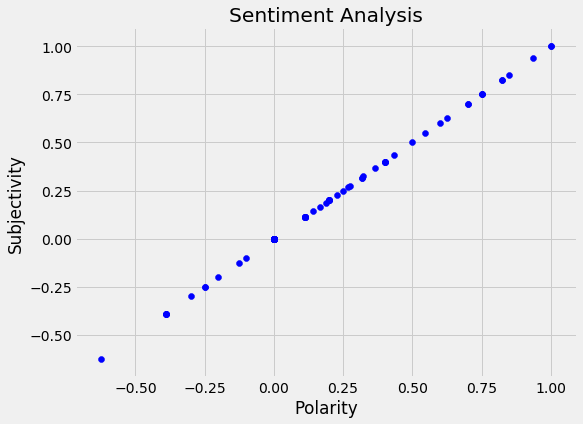

In [106]:
plt.figure(figsize=(8,6)) 
for i in range(0, df.shape[0]):
    plt.scatter(df["Polarity"][i], df["Subjectivity"][i], color='Blue') 
# plt.scatter(x,y,color)   
plt.title('Sentiment Analysis') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()

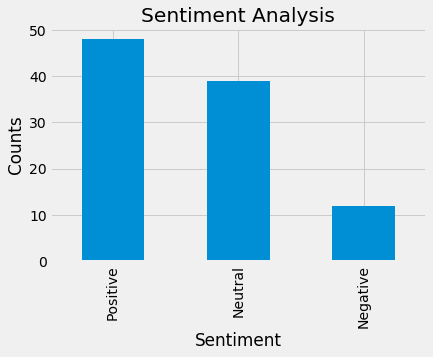

In [107]:
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Outcome'].value_counts().plot(kind = 'bar')
plt.show()